## 1) Configuración y utilidades

In [2]:

DATA_PATH = "TITULADO_2007-2024_web_19_05_2025_E.csv"
ENCODING = "latin-1"
SEP = ";"

import re, numpy as np, pandas as pd, warnings
warnings.filterwarnings("ignore", message="Skipping features without any observed values")

def read_dataset(path, encoding="latin-1", sep=";"):
    return pd.read_csv(path, encoding=encoding, sep=sep, low_memory=False)

def normalize_modality(s: pd.Series) -> pd.Series:
    m = s.astype(str).str.strip().str.lower()
    m = m.replace({
        r"^pres.*": "Presencial",
        r"^no\s*pres.*|^dist.*|^on.?line.*": "No Presencial",
        r"^semi.*": "Semipresencial"
    }, regex=True)
    return m.astype(str).str.title()


## 2) Carga y selección de variables

In [3]:

df = read_dataset(DATA_PATH, ENCODING, SEP)
print("Shape:", df.shape)

age_candidates = ["PROMEDIO EDAD PROGRAMA", "PROMEDIO EDAD PROGRAMA ", "PROMEDIO EDAD TITULADOS", "PROMEDIO EDAD"]
age_col = next((c for c in age_candidates if c in df.columns), None)
assert age_col is not None, "No se encontró la columna de edad promedio general."

cat_cols_expected = ["JORNADA", "CLASIFICACIÓN INSTITUCIÓN NIVEL 1", "REGIÓN", "ÁREA DEL CONOCIMIENTO"]
cat_cols = [c for c in cat_cols_expected if c in df.columns]

assert "MODALIDAD" in df.columns, "No existe MODALIDAD."

use_cols = [age_col] + cat_cols + ["MODALIDAD"]
dfm = df[use_cols].copy()

dfm["MODALIDAD"] = normalize_modality(dfm["MODALIDAD"])
dfm = dfm[dfm["MODALIDAD"].isin(["Presencial","No Presencial","Semipresencial"])].copy()
dfm["MOD_BIN"] = dfm["MODALIDAD"].replace({"Semipresencial":"No Presencial"}).map({"Presencial":0, "No Presencial":1})

dfm = dfm.rename(columns={age_col: "Edad"})
print("Edad col:", age_col)
print("Cat cols:", cat_cols)
print(dfm.head(3))
print("Distribución MOD_BIN:", dfm["MOD_BIN"].value_counts(normalize=True))


Shape: (218566, 42)
Edad col: PROMEDIO EDAD PROGRAMA 
Cat cols: ['JORNADA', 'CLASIFICACIÓN INSTITUCIÓN NIVEL 1', 'REGIÓN', 'ÁREA DEL CONOCIMIENTO']
   Edad      JORNADA CLASIFICACIÓN INSTITUCIÓN NIVEL 1         REGIÓN  \
0  38,7  A Distancia                     Universidades  Metropolitana   
1    29       Diurna                     Universidades  Metropolitana   
2  45,2   Vespertina                     Universidades  Metropolitana   

  ÁREA DEL CONOCIMIENTO      MODALIDAD  MOD_BIN  
0     Ciencias Sociales  No Presencial        1  
1     Ciencias Sociales     Presencial        0  
2     Ciencias Sociales     Presencial        0  
Distribución MOD_BIN: MOD_BIN
0    0.92075
1    0.07925
Name: proportion, dtype: float64


## 3) Limpieza de Edad (coma decimal) e imputación

In [4]:

edad_str = dfm["Edad"].astype(str).str.replace(",", ".", regex=False).str.strip()
dfm["Edad"] = pd.to_numeric(edad_str, errors="coerce")
mediana_edad = dfm["Edad"].median()
dfm["Edad"] = dfm["Edad"].fillna(mediana_edad)

for c in [col for col in dfm.columns if col not in ["Edad","MODALIDAD","MOD_BIN"]]:
    dfm[c] = dfm[c].astype(str).str.strip().replace({"": "Desconocido"}).fillna("Desconocido")

print("Mediana Edad:", mediana_edad)
print("Nulos:", dfm.isna().sum().to_dict())


Mediana Edad: 28.5
Nulos: {'Edad': 0, 'JORNADA': 0, 'CLASIFICACIÓN INSTITUCIÓN NIVEL 1': 0, 'REGIÓN': 0, 'ÁREA DEL CONOCIMIENTO': 0, 'MODALIDAD': 0, 'MOD_BIN': 0}


## 4) Split y preprocesamiento

In [5]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

num_cols = ["Edad"]
cat_cols = [c for c in dfm.columns if c not in ["Edad","MODALIDAD","MOD_BIN"]]

X = dfm[num_cols + cat_cols]
y = dfm["MOD_BIN"]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

preprocess = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
])
print("Shapes -> Train:", X_train.shape, "| Test:", X_test.shape)
print("Cols num:", num_cols, "| Cols cat:", cat_cols)


Shapes -> Train: (134408, 5) | Test: (57604, 5)
Cols num: ['Edad'] | Cols cat: ['JORNADA', 'CLASIFICACIÓN INSTITUCIÓN NIVEL 1', 'REGIÓN', 'ÁREA DEL CONOCIMIENTO']


## 5) Modelo baseline (Logistic Regression) + métricas

In [6]:

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score

model = Pipeline([
    ("prep", preprocess),
    ("clf", LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42))
])
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:,1]

print("=== Métricas (baseline) ===")
print(classification_report(y_test, y_pred, digits=4, zero_division=0))
print("ROC-AUC:", round(roc_auc_score(y_test, y_proba),4))
print("PR-AUC:", round(average_precision_score(y_test, y_proba),4))


=== Métricas (baseline) ===
              precision    recall  f1-score   support

           0     0.9907    0.9671    0.9788     53039
           1     0.7007    0.8944    0.7858      4565

    accuracy                         0.9614     57604
   macro avg     0.8457    0.9308    0.8823     57604
weighted avg     0.9677    0.9614    0.9635     57604

ROC-AUC: 0.9758
PR-AUC: 0.9231


## 6) Optimización de umbral (F1 y F2)

In [7]:

from sklearn.metrics import precision_recall_curve, precision_score, recall_score, f1_score
import numpy as np

def best_threshold_by_f1(y_true, y_proba):
    p, r, thr = precision_recall_curve(y_true, y_proba)
    if len(thr) == 0:
        return 0.5, 0.0
    f1_vals = []
    for i in range(len(thr)):
        pi, ri = p[i+1], r[i+1]
        f1_vals.append(0.0 if (pi+ri)==0 else 2*pi*ri/(pi+ri))
    j = int(np.argmax(f1_vals))
    return float(thr[j]), float(f1_vals[j])

def best_threshold_by_fbeta(y_true, y_proba, beta=2.0):
    p, r, thr = precision_recall_curve(y_true, y_proba)
    if len(thr) == 0:
        return 0.5, 0.0
    b2 = beta**2
    f_vals = []
    for i in range(len(thr)):
        pi, ri = p[i+1], r[i+1]
        denom = b2*pi + ri
        f = 0.0 if denom<=0 else (1+b2)*pi*ri/denom
        f_vals.append(f)
    j = int(np.argmax(f_vals))
    return float(thr[j]), float(f_vals[j])

thr_f1, f1_val = best_threshold_by_f1(y_test, y_proba)
thr_f2, f2_val = best_threshold_by_fbeta(y_test, y_proba, beta=2.0)

def eval_with_thr(y_true, y_proba, thr, tag):
    y_hat = (y_proba > thr).astype(int)
    print(f"[{tag}] thr={thr:.3f} | precision={precision_score(y_true, y_hat, zero_division=0):.3f} | recall={recall_score(y_true, y_hat, zero_division=0):.3f} | f1={f1_score(y_true, y_hat, zero_division=0):.3f}")

print(f"Mejor umbral por F1 (TEST): {thr_f1:.3f} (F1={f1_val:.3f})")
eval_with_thr(y_test, y_proba, thr_f1, "TEST F1-opt")

print(f"Mejor umbral por F2 (TEST): {thr_f2:.3f} (F2={f2_val:.3f})")
eval_with_thr(y_test, y_proba, thr_f2, "TEST F2-opt")


Mejor umbral por F1 (TEST): 0.978 (F1=0.906)
[TEST F1-opt] thr=0.978 | precision=1.000 | recall=0.829 | f1=0.906
Mejor umbral por F2 (TEST): 0.978 (F2=0.858)
[TEST F2-opt] thr=0.978 | precision=1.000 | recall=0.829 | f1=0.906


## 7) Interpretabilidad (coeficientes ordenados)

In [8]:

ohe = model.named_steps["prep"].transformers_[1][1]
cat_feature_names = list(ohe.get_feature_names_out([c for c in cat_cols]))
feature_names = ["Edad"] + cat_feature_names

coefs = model.named_steps["clf"].coef_[0]
imp = pd.DataFrame({"Feature": feature_names, "Coef": coefs})
imp["AbsCoef"] = imp["Coef"].abs()
imp = imp.sort_values("AbsCoef", ascending=False)

print("=== Top 20 características ===")
imp.head(20)


=== Top 20 características ===


,Feature,Coef,AbsCoef
1,JORNADA_A Distancia,6.512521,6.512521
4,JORNADA_Semipresencial,6.380876,6.380876
2,JORNADA_Diurna,-4.742701,4.742701
3,JORNADA_Otra,-3.713982,3.713982
5,JORNADA_Vespertina,-3.655501,3.655501
16,REGIÓN_Lib. Gral. B. O'Higgins,-2.126995,2.126995
25,ÁREA DEL CONOCIMIENTO_Administración y Comercio,1.575389,1.575389
11,REGIÓN_Atacama,1.455888,1.455888
27,ÁREA DEL CONOCIMIENTO_Arte y Arquitectura,-1.038552,1.038552
28,ÁREA DEL CONOCIMIENTO_Ciencias Básicas,-1.005381,1.005381


## 8) Export de artefactos

In [9]:

import os
from sklearn.metrics import roc_auc_score, average_precision_score

os.makedirs("../data/edad_modalidad_artifacts_v3", exist_ok=True)
imp.head(50).to_csv("../data/edad_modalidad_artifacts_v3/top_features.csv", index=False)

summary = pd.DataFrame([{
    "roc_auc": roc_auc_score(y_test, y_proba),
    "pr_auc": average_precision_score(y_test, y_proba),
    "thr_f1": thr_f1,
    "thr_f2": thr_f2
}])
summary.to_csv("../data/edad_modalidad_artifacts_v3/summary_metrics.csv", index=False)

print("Guardado: ../data/edad_modalidad_artifacts_v3/top_features.csv")
print("Guardado: ../data/edad_modalidad_artifacts_v3/summary_metrics.csv")


Guardado: ../data/edad_modalidad_artifacts_v3/top_features.csv
Guardado: ../data/edad_modalidad_artifacts_v3/summary_metrics.csv


## 9) Predicciones individuales y escenarios

Usamos el **pipeline `model`** entrenado para estimar la probabilidad de **No Presencial** en perfiles individuales y múltiples escenarios.
- La probabilidad corresponde a `model.predict_proba()[:, 1]`.
- Si definiste un umbral óptimo en la sección 6 (`thr_f2` o `thr_f1`), se aplicará como **umbral operativo**; de lo contrario se usa 0.5.


In [10]:
import pandas as pd
import numpy as np

# Umbral operativo (prioriza F2 si existe; si no, F1; si no, 0.5)
try:
    thr_operativo = float(thr_f2)
except Exception:
    try:
        thr_operativo = float(thr_f1)
    except Exception:
        thr_operativo = 0.5

print(f"Umbral operativo usado: {thr_operativo:.3f}")

persona = pd.DataFrame([{
    "Edad": 20,
    "JORNADA": "Diurna",
    "CLASIFICACIÓN INSTITUCIÓN NIVEL 1": "Institutos Profesionales",
    "REGIÓN": "Atacama",
    "ÁREA DEL CONOCIMIENTO": "Administración y Comercio"
}])

print("=== Predicción individual ===")
print("Perfil de la persona:")
print(persona)

prob = model.predict_proba(persona)[:, 1][0]
pred = "No Presencial" if prob > thr_operativo else "Presencial"
print(f"Probabilidad de modalidad No Presencial: {prob:.2%}")
print("Clasificación (umbral aplicado):", pred)

# === 9.2 Comparación de escenarios ===
scenarios = pd.DataFrame([
    {"Edad": 22, "JORNADA": "Diurna", "CLASIFICACIÓN INSTITUCIÓN NIVEL 1": "Universidades",
     "REGIÓN": "Metropolitana", "ÁREA DEL CONOCIMIENTO": "Salud"},
    {"Edad": 30, "JORNADA": "Vespertina", "CLASIFICACIÓN INSTITUCIÓN NIVEL 1": "Institutos Profesionales",
     "REGIÓN": "Valparaíso", "ÁREA DEL CONOCIMIENTO": "Administración y Comercio"},
    {"Edad": 40, "JORNADA": "A Distancia", "CLASIFICACIÓN INSTITUCIÓN NIVEL 1": "Centro de Formación Técnica",
     "REGIÓN": "Arica y Parinacota", "ÁREA DEL CONOCIMIENTO": "Educación"}
])

probs = model.predict_proba(scenarios)[:, 1]
scenarios["Prob_NoPresencial(%)"] = (probs * 100).round(1)
scenarios["Prediccion"] = np.where(probs > thr_operativo, "No Presencial", "Presencial")
scenarios


Umbral operativo usado: 0.978
=== Predicción individual ===
Perfil de la persona:
   Edad JORNADA CLASIFICACIÓN INSTITUCIÓN NIVEL 1   REGIÓN  \
0    20  Diurna          Institutos Profesionales  Atacama   

       ÁREA DEL CONOCIMIENTO  
0  Administración y Comercio  
Probabilidad de modalidad No Presencial: 26.84%
Clasificación (umbral aplicado): Presencial


,Edad,JORNADA,CLASIFICACIÓN INSTITUCIÓN NIVEL 1,REGIÓN,ÁREA DEL CONOCIMIENTO,Prob_NoPresencial(%),Prediccion
0,22,Diurna,Universidades,Metropolitana,Salud,1.8,Presencial
1,30,Vespertina,Institutos Profesionales,Valparaíso,Administración y Comercio,49.6,Presencial
2,40,A Distancia,Centro de Formación Técnica,Arica y Parinacota,Educación,100.0,No Presencial


## 10)  EJEMPLO Y ANÁLISIS VISUAL


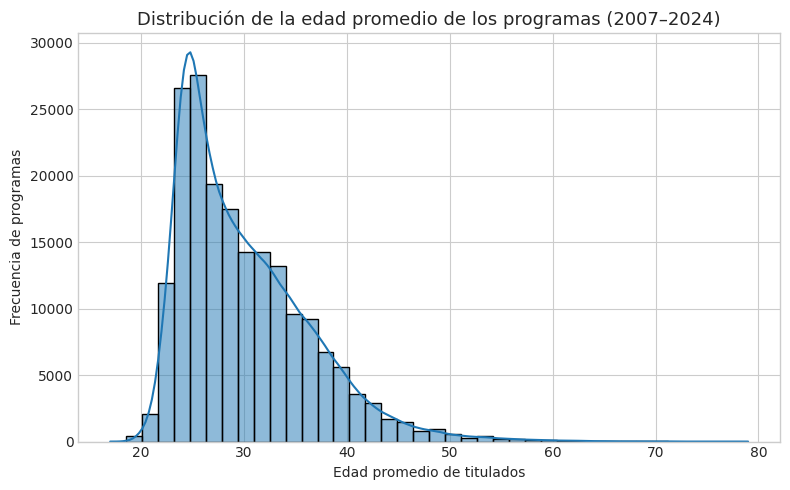

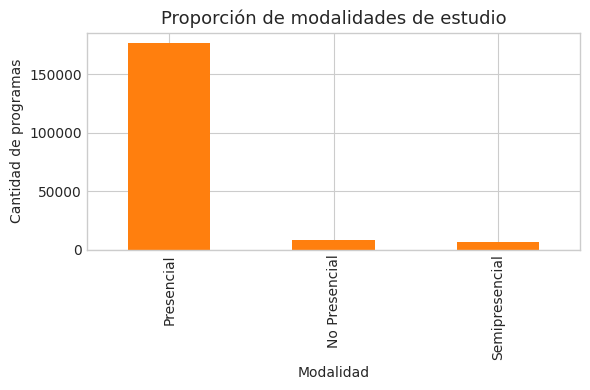

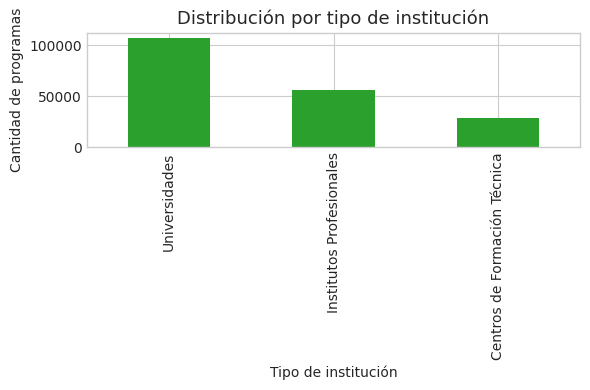

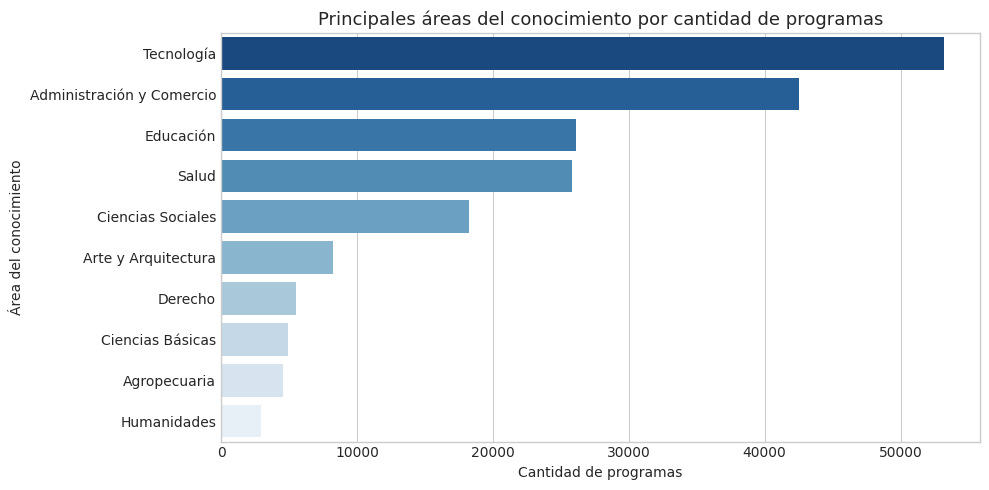

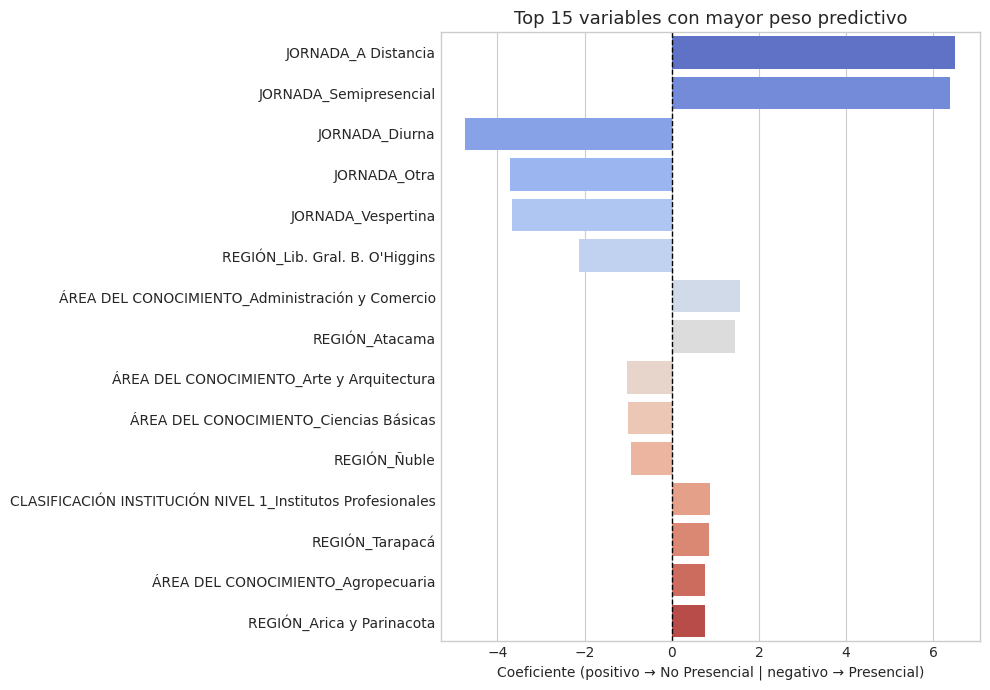

In [11]:

import matplotlib.pyplot as plt
import seaborn as sns
import textwrap

plt.style.use("seaborn-v0_8-whitegrid")

# 1️⃣ DISTRIBUCIÓN DE EDAD
plt.figure(figsize=(8,5))
sns.histplot(dfm["Edad"], bins=40, color="#1f77b4", kde=True)
plt.title("Distribución de la edad promedio de los programas (2007–2024)", fontsize=13)
plt.xlabel("Edad promedio de titulados")
plt.ylabel("Frecuencia de programas")
plt.tight_layout()
plt.show()

# 2️⃣ DISTRIBUCIÓN DE MODALIDAD
plt.figure(figsize=(6,4))
dfm["MODALIDAD"].value_counts().plot(kind="bar", color="#ff7f0e")
plt.title("Proporción de modalidades de estudio", fontsize=13)
plt.ylabel("Cantidad de programas")
plt.xlabel("Modalidad")
plt.tight_layout()
plt.show()

# 3️⃣ TIPO DE INSTITUCIÓN
plt.figure(figsize=(6,4))
dfm["CLASIFICACIÓN INSTITUCIÓN NIVEL 1"].value_counts().plot(kind="bar", color="#2ca02c")
plt.title("Distribución por tipo de institución", fontsize=13)
plt.ylabel("Cantidad de programas")
plt.xlabel("Tipo de institución")
plt.tight_layout()
plt.show()

# 4️⃣ ÁREA DEL CONOCIMIENTO
plt.figure(figsize=(10,5))
top_areas = dfm["ÁREA DEL CONOCIMIENTO"].value_counts().head(10)
sns.barplot(
    x=top_areas.values, 
    y=top_areas.index, 
    hue=top_areas.index,       # se usa hue igual al eje Y
    palette="Blues_r", 
    legend=False               # evita duplicar leyenda
)

plt.title("Principales áreas del conocimiento por cantidad de programas", fontsize=13)
plt.xlabel("Cantidad de programas")
plt.ylabel("Área del conocimiento")
plt.tight_layout()
plt.show()

# 5️⃣ COEFICIENTES DEL MODELO
plt.figure(figsize=(10,7))
top_feats = imp.sort_values("AbsCoef", ascending=False).head(15)
sns.barplot(
    x="Coef", 
    y="Feature", 
    data=top_feats, 
    hue="Feature",             # asignamos hue explícito
    palette="coolwarm", 
    legend=False
)

plt.axvline(0, color="black", linestyle="--", linewidth=1)
plt.title("Top 15 variables con mayor peso predictivo", fontsize=13)
plt.xlabel("Coeficiente (positivo → No Presencial | negativo → Presencial)")
plt.ylabel("")
plt.tight_layout()
plt.show()
